In [7]:
import tensorflow as tf
import keras
from keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import (BatchNormalization, Conv2D, Add, MaxPooling2D, Activation, Flatten, Dropout, Dense, UpSampling2D, GlobalAveragePooling2D)
from keras.utils import to_categorical
from keras.losses import CategoricalCrossentropy , KLDivergence
from keras.metrics import CategoricalAccuracy
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt

170498071/170498071 [==============================] - 13s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


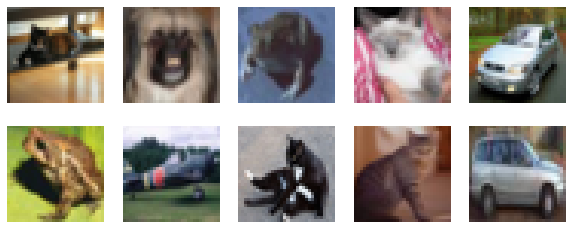

In [2]:
num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Visualizing CIFAR 10
fig, axes1 = plt.subplots(2,5,figsize=(10,4))
for j in range(2):
  for k in range(5):
    i = np.random.choice(range(len(x_train)))
    axes1[j][k].set_axis_off()
    axes1[j][k].imshow(x_train[i:i+1][0])
        

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255.
#x_test /= 255.

In [3]:
#preprocess according to ResNet50 requirements
x_train = preprocess_input(x_train)
x_test = preprocess_input(x_test)

In [4]:
def visualize_loss_and_acc(history):
  history_dict = history.history
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  acc = history_dict['categorical_accuracy']

  epochs = range(1, len(acc) + 1)

  f = plt.figure(figsize=(10,3))

  plt.subplot(1,2,1)
  plt.plot(epochs, loss_values, 'bo', label='Training loss')
  plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()


  acc_values = history_dict['categorical_accuracy']
  val_acc = history_dict['val_categorical_accuracy']

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

# الف)

In [5]:
conv_base = ResNet50(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
conv_base.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [6]:
teacher_linTune = Sequential()
teacher_linTune.add(UpSampling2D((7,7))) #resize to 224*224
teacher_linTune.add(conv_base)
teacher_linTune.add(Flatten())
teacher_linTune.add(Dense(num_classes))
teacher_linTune.layers[1].trainable = False
#teacher_linTune.layers[1].name

teacher_linTune.build(input_shape=(None, 32, 32, 3))
teacher_linTune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 10)                1003530   
                                                                 
Total params: 24,591,242
Trainable params: 1,003,530
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
#sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
teacher_linTune.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=[CategoricalAccuracy()],
)
history = teacher_linTune.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test),shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 188s 113ms/step - loss: 0.8388 - categorical_accuracy: 0.7362 - val_loss: 0.6279 - val_categorical_accuracy: 0.7966
Epoch 2/10
1563/1563 [==============================] - 189s 121ms/step - loss: 0.3707 - categorical_accuracy: 0.8759 - val_loss: 0.5730 - val_categorical_accuracy: 0.8181
Epoch 3/10
1563/1563 [==============================] - 176s 113ms/step - loss: 0.2080 - categorical_accuracy: 0.9323 - val_loss: 0.5660 - val_categorical_accuracy: 0.8219
Epoch 4/10
1563/1563 [==============================] - 175s 112ms/step - loss: 0.1200 - categorical_accuracy: 0.9673 - val_loss: 0.5266 - val_categorical_accuracy: 0.8393
Epoch 5/10
1563/1563 [==============================] - 175s 112ms/step - loss: 0.0706 - categorical_accuracy: 0.9861 - val_loss: 0.5530 - val_categorical_accuracy: 0.8356
Epoch 6/10
1563/1563 [==============================] - 175s 112ms/step - loss: 0.0416 - categorical_accuracy: 0.9950 - val_loss: 0.5368 - v

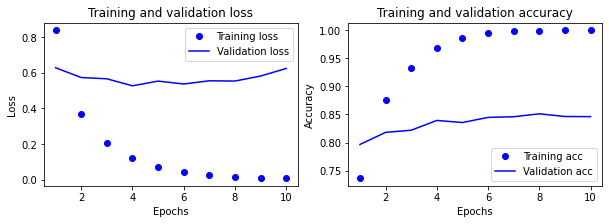

313/313 [==============================] - 29s 93ms/step - loss: 0.6239 - categorical_accuracy: 0.8461
Test accuracy of Student Model from Scratch: 0.8460999727249146


In [9]:
visualize_loss_and_acc(history)
# Score trained model.
scores = teacher_linTune.evaluate(x_test, y_test, verbose=1)
print('Test accuracy of Student Model from Scratch:', scores[1])

the first model is overfit. in orther to slove the problem, I tried to reduce number of parameters by adding average global pooling before FC layer.

In [17]:
conv_base2 = ResNet50(weights='imagenet', include_top=False,pooling='avg',input_shape=(224, 224, 3)) #add global avg pooling to avoid overfitting

teacher_linTune2 = Sequential()
teacher_linTune2.add(UpSampling2D((7,7)))
teacher_linTune2.add(conv_base2)
teacher_linTune2.add(Dense(num_classes))
teacher_linTune2.layers[1].trainable = False


teacher_linTune2.build(input_shape=(None, 32, 32, 3))
teacher_linTune2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_4 (UpSampling  (None, 224, 224, 3)      0         
 2D)                                                             
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 20,490
Non-trainable params: 23,587,712
_________________________________________________________________


In [18]:
teacher_linTune2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=[CategoricalAccuracy()],
)
history2 = teacher_linTune2.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test),shuffle=True)

Epoch 1/5
1563/1563 [==============================] - 178s 112ms/step - loss: 0.7099 - categorical_accuracy: 0.7552 - val_loss: 0.6170 - val_categorical_accuracy: 0.7856
Epoch 2/5
1563/1563 [==============================] - 174s 112ms/step - loss: 0.5217 - categorical_accuracy: 0.8197 - val_loss: 0.5440 - val_categorical_accuracy: 0.8145
Epoch 3/5
1563/1563 [==============================] - 174s 111ms/step - loss: 0.4725 - categorical_accuracy: 0.8364 - val_loss: 0.5458 - val_categorical_accuracy: 0.8160
Epoch 4/5
1563/1563 [==============================] - 174s 112ms/step - loss: 0.4410 - categorical_accuracy: 0.8477 - val_loss: 0.5705 - val_categorical_accuracy: 0.8060
Epoch 5/5
1563/1563 [==============================] - 175s 112ms/step - loss: 0.4145 - categorical_accuracy: 0.8552 - val_loss: 0.5048 - val_categorical_accuracy: 0.8330


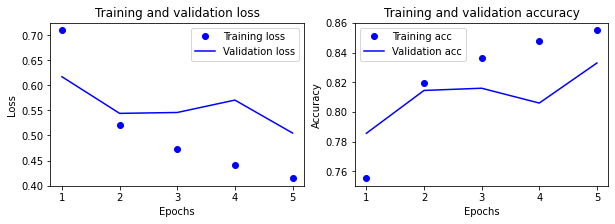

313/313 [==============================] - 29s 93ms/step - loss: 0.5048 - categorical_accuracy: 0.8330
Test accuracy of Student Model from Scratch: 0.8330000042915344


In [19]:
visualize_loss_and_acc(history2)
# Score trained model.
scores = teacher_linTune2.evaluate(x_test, y_test, verbose=1)
print('Test accuracy of Teacher linear tuned:', scores[1])

new model loss and accuracy didn't improve much but overfit problem is solved.

in another attempt, I tried to normalize dataset by 1/255 . model in that case was not overfit at all but the resulting accuracy was not enough(around 45%) so I removed it.

# ب)

In [20]:
#code taken from kaggle
"""
ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""




class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.upsample = UpSampling2D((7,7)) #resize 32*32 to 224*224
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPooling2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes)

    def call(self, inputs):
        out = self.upsample(inputs)
        out = self.conv_1(out)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out



In [21]:
#code taken from https://keras.io/examples/vision/knowledge_distillation/
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3.,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        x, y = data

        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)

            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )

            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [24]:
# Initialize and compile distiller
student = ResNet18(10)
distiller = Distiller(student=student, teacher=teacher_linTune2)
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate =1e-4),
    metrics=[CategoricalAccuracy()],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= KLDivergence(),
    alpha=0.1,
    temperature=10.,
)

# Distill teacher to student
history = distiller.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/5
1563/1563 [==============================] - 325s 206ms/step - categorical_accuracy: 0.5590 - student_loss: 1.3959 - distillation_loss: 4.6712 - val_categorical_accuracy: 0.6184 - val_student_loss: 1.3967
Epoch 2/5
1563/1563 [==============================] - 322s 206ms/step - categorical_accuracy: 0.7111 - student_loss: 0.8777 - distillation_loss: 2.9344 - val_categorical_accuracy: 0.6987 - val_student_loss: 1.7352
Epoch 3/5
1563/1563 [==============================] - 321s 206ms/step - categorical_accuracy: 0.7715 - student_loss: 0.6803 - distillation_loss: 2.3478 - val_categorical_accuracy: 0.7587 - val_student_loss: 0.8287
Epoch 4/5
1563/1563 [==============================] - 322s 206ms/step - categorical_accuracy: 0.8004 - student_loss: 0.5799 - distillation_loss: 1.9950 - val_categorical_accuracy: 0.7486 - val_student_loss: 0.9520
Epoch 5/5
1563/1563 [==============================] - 322s 206ms/step - categorical_accuracy: 0.8225 - student_loss: 0.5108 - distillation_

In [25]:
# Evaluate student on test dataset
scores = distiller.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy of Student Model: ", scores[0])

313/313 [==============================] - 10s 33ms/step - categorical_accuracy: 0.7987 - student_loss: 0.6009
Test Accuracy of Student Model:  0.7986999750137329


In [26]:
# Initialize and compile distiller
student = ResNet18(10)
distiller = Distiller(student=student, teacher=teacher_linTune2)
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate =1e-4),
    metrics=[CategoricalAccuracy()],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= KLDivergence(),
    alpha=0.05,
    temperature=15.,
)

# Distill teacher to student
history = distiller.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/5
1563/1563 [==============================] - 327s 207ms/step - categorical_accuracy: 0.5625 - student_loss: 1.3889 - distillation_loss: 4.5110 - val_categorical_accuracy: 0.6212 - val_student_loss: 1.4876
Epoch 2/5
1563/1563 [==============================] - 322s 206ms/step - categorical_accuracy: 0.7147 - student_loss: 0.8769 - distillation_loss: 2.8541 - val_categorical_accuracy: 0.7056 - val_student_loss: 0.7946
Epoch 3/5
1563/1563 [==============================] - 321s 205ms/step - categorical_accuracy: 0.7687 - student_loss: 0.6909 - distillation_loss: 2.3102 - val_categorical_accuracy: 0.6899 - val_student_loss: 1.0384
Epoch 4/5
1563/1563 [==============================] - 321s 206ms/step - categorical_accuracy: 0.7973 - student_loss: 0.5907 - distillation_loss: 1.9733 - val_categorical_accuracy: 0.7368 - val_student_loss: 0.9181
Epoch 5/5
1563/1563 [==============================] - 321s 206ms/step - categorical_accuracy: 0.8148 - student_loss: 0.5348 - distillation_

In [27]:
# Evaluate student on test dataset
scores = distiller.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy of Student Model: ", scores[0])

313/313 [==============================] - 10s 33ms/step - categorical_accuracy: 0.7620 - student_loss: 0.7114
Test Accuracy of Student Model:  0.7620000243186951


In [28]:
# Initialize and compile distiller
student = ResNet18(10)
distiller = Distiller(student=student, teacher=teacher_linTune2)
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate =1e-4),
    metrics=[CategoricalAccuracy()],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= KLDivergence(),
    alpha=0.01,
    temperature=10.,
)

# Distill teacher to student
history = distiller.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/5
1563/1563 [==============================] - 327s 206ms/step - categorical_accuracy: 0.5675 - student_loss: 1.3874 - distillation_loss: 4.5583 - val_categorical_accuracy: 0.6030 - val_student_loss: 1.3461
Epoch 2/5
1563/1563 [==============================] - 322s 206ms/step - categorical_accuracy: 0.7142 - student_loss: 0.8761 - distillation_loss: 2.8392 - val_categorical_accuracy: 0.7082 - val_student_loss: 1.0793
Epoch 3/5
1563/1563 [==============================] - 321s 205ms/step - categorical_accuracy: 0.7662 - student_loss: 0.6909 - distillation_loss: 2.2821 - val_categorical_accuracy: 0.7361 - val_student_loss: 0.8799
Epoch 4/5
1563/1563 [==============================] - 323s 206ms/step - categorical_accuracy: 0.7953 - student_loss: 0.5942 - distillation_loss: 1.9533 - val_categorical_accuracy: 0.7655 - val_student_loss: 0.9355
Epoch 5/5
1563/1563 [==============================] - 322s 206ms/step - categorical_accuracy: 0.8152 - student_loss: 0.5362 - distillation_

In [29]:
# Evaluate student on test dataset
scores = distiller.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy of Student Model: ", scores[0])

313/313 [==============================] - 10s 33ms/step - categorical_accuracy: 0.7239 - student_loss: 0.9086
Test Accuracy of Student Model:  0.7239000201225281


In [30]:
#Initialize and compile distiller
student = ResNet18(10)
distiller = Distiller(student=student, teacher=teacher_linTune2)
distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate =1e-4),
    metrics=[CategoricalAccuracy()],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn= KLDivergence(),
    alpha=0.2,
    temperature=8.,
)

# Distill teacher to student
history = distiller.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test), batch_size=32)

Epoch 1/5
1563/1563 [==============================] - 328s 207ms/step - categorical_accuracy: 0.5696 - student_loss: 1.3434 - distillation_loss: 4.5776 - val_categorical_accuracy: 0.6118 - val_student_loss: 1.7160
Epoch 2/5
1563/1563 [==============================] - 324s 207ms/step - categorical_accuracy: 0.7228 - student_loss: 0.8363 - distillation_loss: 2.8704 - val_categorical_accuracy: 0.6980 - val_student_loss: 1.7184
Epoch 3/5
1563/1563 [==============================] - 324s 207ms/step - categorical_accuracy: 0.7814 - student_loss: 0.6405 - distillation_loss: 2.2695 - val_categorical_accuracy: 0.7673 - val_student_loss: 1.0000
Epoch 4/5
1563/1563 [==============================] - 323s 207ms/step - categorical_accuracy: 0.8155 - student_loss: 0.5336 - distillation_loss: 1.9210 - val_categorical_accuracy: 0.7794 - val_student_loss: 0.7072
Epoch 5/5
1563/1563 [==============================] - 323s 207ms/step - categorical_accuracy: 0.8394 - student_loss: 0.4613 - distillation_

In [31]:
# Evaluate student on test dataset
scores = distiller.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy of Student Model: ", scores[0])

313/313 [==============================] - 11s 34ms/step - categorical_accuracy: 0.7665 - student_loss: 0.7241
Test Accuracy of Student Model:  0.7664999961853027


best model achieved using alpha=0.1 and T = 10